# Generalized Time-Extended Networks
This Notebook explains how to use the code base to create a generalized time-expanded network.

In [1]:
from auxiliary_functions_index.networkx_utilities import create_graph, visualize_graph, find_cut_edges
from auxiliary_functions_index.generalized_ext_network import aggregate_cut_time_points, create_A_inf, get_time_level
from auxiliary_functions_index.min_cut_LP import min_cut_over_time
import itertools
import pandas as pd

## Data
We consider a network (directed graph) where each arc has a capacity and a transit time. There are two designated subsets of nodes: sources and sinks. Additionally we need to specify a time horizon. 

In [2]:
arcs = [(1, 2), (1, 3), (2, 4), (3, 4), (2, 3)]  # Arcs in the network
capacities = {(1, 2): 1, (1, 3): 1, (2, 4): 1, (3, 4): 2, (2, 3): 2}  # Cost for each arc in the objective
transit_times = {(1, 2): 1, (1, 3): 1, (2, 4): 1, (3, 4): 1, (2, 3):0}  # Right-hand side values for each arc constraint
sources = [1]  # Nodes in S+ ∩ X where α should be 0
sinks = [4]  # Nodes in S- \ X where α should be T
time_horizon = 4  # The value of T

1. Step: Compute a Min Cut Over Time

In [3]:
# Compute the min cut values 
alpha, _ = min_cut_over_time(arcs, capacities, transit_times, time_horizon, sources, sinks)

Set parameter Username


Academic license - for non-commercial use only - expires 2025-11-05
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: AMD Ryzen 7 5700U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 9 rows, 12 columns and 23 nonzeros
Model fingerprint: 0xbb41c9b9
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+00]
Presolve removed 5 rows and 7 columns
Presolve time: 0.01s
Presolved: 4 rows, 5 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.000000e+00   0.000000e+00      0s
       4    4.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds (0.00 work units)
Optimal objective  4.000000000e+00
Optimal objective value: 4.0
y[(1, 2)] = 2.0
y[(1, 3)

Visualization of the results. Alpha labels indicate the minimum cut over time.

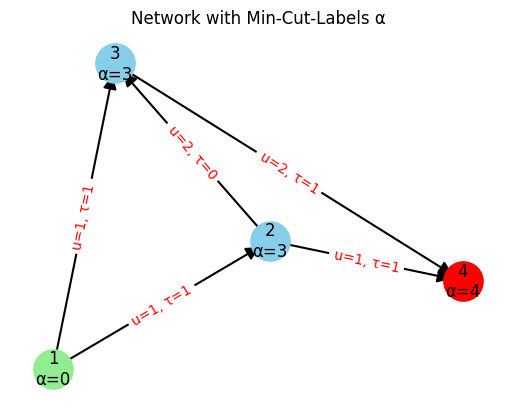

In [4]:
# Create the graph and display the Min-Cut-values
G = create_graph(arcs, capacities, transit_times, alpha=alpha)
visualize_graph(G, sources, sinks)

2. Step: Find all interesting time points 
$$\overset{\sim}{T} = \bigcup_{X\subset S\ :\ X\cap S^+ \neq \emptyset,\ S^-\setminus X \neq \emptyset } \{\alpha_{v,X} : v\in V\}$$

In [5]:
# Compute "interesting" time points, i.e. all time points of cuts over time for different subsets of terminals
time_points = aggregate_cut_time_points(sources, sinks, arcs, capacities, transit_times, time_horizon)
print('\n\nT~ =', time_points)

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: AMD Ryzen 7 5700U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 9 rows, 12 columns and 23 nonzeros
Model fingerprint: 0xbb41c9b9
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+00]
Presolve removed 5 rows and 7 columns
Presolve time: 0.00s
Presolved: 4 rows, 5 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.000000e+00   0.000000e+00      0s
       4    4.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds (0.00 work units)
Optimal objective  4.000000000e+00
Optimal objective value: 4.0
y[(1, 2)] = 2.0
y[(1, 3)] = 2.0
y[(2, 4)] = 0.0
y[(3, 4)] = 0.0
y[(2, 3)] = 0.0
y[('psi', 1)

In [6]:
# Create two dctionaries assigning to each alpha-value (time point) the number of its coresponding time layer and vice versa
alpha_to_index = {time: idx + 1 for idx, time in enumerate(time_points)}
index_to_alpha = dict(enumerate(time_points, start=1))

## Construction of the generalized time-expanded network
- Nodes $V^{\overset{\sim}{T}} = \{v^i : i \in \{1,\ldots,\overset{\sim}{T}\}, v\in V\}$
- "upward" arcs $A_{\infty}$
- arcs $A_{<\infty}$

3. Step: Construction of $A_\infty$

In [ ]:
nodes = list(set([node for arc in arcs for node in arc]))
nodes_T_tilde = [f'{node}^{t}' for node, t in itertools.product(nodes, index_to_alpha.keys())]
#print(nodes_T_tilde)
A_inf, capacities_inf, lengths_inf = create_A_inf(nodes, index_to_alpha)
df_inf = pd.DataFrame({
    'v': [arc[0] for arc in A_inf],
    'w': [arc[1] for arc in A_inf],
    'capacity': [capacities_inf[arc] for arc in A_inf],
    'length': [lengths_inf[arc] for arc in A_inf]
})
print('A_inf')
df_inf

A_inf


,v,w,capacity,length
0,1^1,1^2,10000,1
1,1^2,1^3,10000,1
2,2^1,2^2,10000,1
3,2^2,2^3,10000,1
4,3^1,3^2,10000,1
5,3^2,3^3,10000,1
6,4^1,4^2,10000,1
7,4^2,4^3,10000,1


3. Step: Construction of $A_{<\infty}$

In [8]:
def create_A_fin(arcs, time_points, original_capacities, original_transit_times):

    # Initialize the finite capacity arcs with capacity and compute their length
    A_fin = []
    new_capacities = {}
    original_capacities_dict = {}
    original_transit_times_dict = {}
    length = {}

    # Loop over arcs and time points to compute the capacity and length for each inter-time-layer arc in the extened network
    for arc in arcs:
        v, w = arc
        for i in range(len(time_points)):
            # Initialize vi which is the i-th copy of the original node v
            vi = f'{v}^{time_points[i]}'
            for j in range(i,len(time_points)):
                # Initialize wj which is the j-th copy of the original node w
                wj = f'{w}^{time_points[j]}'
                # add arc vi,wj, compute the length of the arc and initialize the new capacity with 0
                A_fin.append((vi,wj))
                new_capacities[(vi,wj)] = 0
                length[(vi,wj)] = time_points[j]-time_points[i]
                original_capacities_dict[(vi,wj)] = original_capacities[v,w]
                original_transit_times_dict[(vi,wj)] = original_transit_times[v,w]

    #A_fin, new_capacities, lengths_fin, original_capacities, original_transit_times = create_A_fin(arcs, time_points, capacities, transit_times)
    df_fin = pd.DataFrame({
        'v': [arc[0] for arc in A_fin],
        'w': [arc[1] for arc in A_fin],
        'capacity': [new_capacities[arc] for arc in A_fin],
        'length': [length[arc] for arc in A_fin],
        'original_capacity': [original_capacities_dict[arc] for arc in A_fin],
        'original_transit_time': [original_transit_times_dict[arc] for arc in A_fin]
    })

    return df_fin

df_fin = create_A_fin(arcs, time_points, capacities, transit_times)

print('A_fin')
df_fin.head()

A_fin


,v,w,capacity,length,original_capacity,original_transit_time
0,1^0,2^0,0,0,1,1
1,1^0,2^3,0,3,1,1
2,1^0,2^4,0,4,1,1
3,1^3,2^3,0,0,1,1
4,1^3,2^4,0,1,1,1


In [9]:
df = pd.concat([df_inf, df_fin], ignore_index=True)
df['edge'] = [(row.v, row.w) for _, row in df.iterrows()]
#print('The generalized time-extended graphs edge set: ', A_ext)
df.head(15)

,v,w,capacity,length,original_capacity,original_transit_time,edge
0,1^1,1^2,10000,1,NaN,NaN,"(1^1, 1^2)"
1,1^2,1^3,10000,1,NaN,NaN,"(1^2, 1^3)"
2,2^1,2^2,10000,1,NaN,NaN,"(2^1, 2^2)"
3,2^2,2^3,10000,1,NaN,NaN,"(2^2, 2^3)"
4,3^1,3^2,10000,1,NaN,NaN,"(3^1, 3^2)"
5,3^2,3^3,10000,1,NaN,NaN,"(3^2, 3^3)"
6,4^1,4^2,10000,1,NaN,NaN,"(4^1, 4^2)"
7,4^2,4^3,10000,1,NaN,NaN,"(4^2, 4^3)"
8,1^0,2^0,0,0,1.0,1.0,"(1^0, 2^0)"
9,1^0,2^3,0,3,1.0,1.0,"(1^0, 2^3)"


In [10]:
A_fin = []

for arc in arcs:
    v, w = arc
    for i in range(len(time_points)):
        # Initialize vi which is the i-th copy of the original node v
        vi = f'{v}^{time_points[i]}'
        for j in range(i,len(time_points)):
            # Initialize wj which is the j-th copy of the original node w
            wj = f'{w}^{time_points[j]}'
            # add arc vi,wj, compute the length of the arc and initialize the new capacity with 0
            A_fin.append((vi,wj))
A_fin

[('1^0', '2^0'),
 ('1^0', '2^3'),
 ('1^0', '2^4'),
 ('1^3', '2^3'),
 ('1^3', '2^4'),
 ('1^4', '2^4'),
 ('1^0', '3^0'),
 ('1^0', '3^3'),
 ('1^0', '3^4'),
 ('1^3', '3^3'),
 ('1^3', '3^4'),
 ('1^4', '3^4'),
 ('2^0', '4^0'),
 ('2^0', '4^3'),
 ('2^0', '4^4'),
 ('2^3', '4^3'),
 ('2^3', '4^4'),
 ('2^4', '4^4'),
 ('3^0', '4^0'),
 ('3^0', '4^3'),
 ('3^0', '4^4'),
 ('3^3', '4^3'),
 ('3^3', '4^4'),
 ('3^4', '4^4'),
 ('2^0', '3^0'),
 ('2^0', '3^3'),
 ('2^0', '3^4'),
 ('2^3', '3^3'),
 ('2^3', '3^4'),
 ('2^4', '3^4')]

In [11]:

def cut_capacity(graph, set_from, set_to):
    """
    Computes the capacity of a cut in a directed graph.

    Parameters:
    graph (networkx.DiGraph): A directed graph where each edge has a 'capacity' attribute.
    set_from (set): Set of nodes on one side of the cut.
    set_to (set): Set of nodes on the other side of the cut.

    Returns:
    int or float: The total capacity of edges crossing from set_s to set_t.
    """
    # Make sure, each node is only contained once in the sets set_from and set_to
    set_from = list(set(set_from))
    set_to = list(set(set_to))

    cut_capacity = 0
    for u in set_from:
        for v in graph.successors(u):
            if v in set_to:
                cut_capacity += graph[u][v].get('capacity', 0)
    return cut_capacity


#G_ext = create_graph(A=df['edge'], u=df['capacity'].to_dict(), tau=df['length'])
#cut_capacity(G_ext, ['1^0'], ['3^3'])

In [12]:

def calculate_u(v_i, w_i1, u_a, alpha, tau_a, j, i, ell, lookup):
    """
    Calculates u for the given parameters.

    Parameters:
    v_i, w_i1 : Not used directly in calculation, assumed for completeness
    u_a : Constant or variable for u
    alpha : List or dict holding alpha values
    tau_a : Constant or variable for tau
    j, i : Indices for lookup
    ell : Offset for alpha and lookup
    lookup : 2D list or dict for [j, i + ell]_a term

    Returns:
    float : The calculated u value.
    """
    # Access the required alpha values
    alpha_i = alpha[i]
    alpha_i_ell_1 = alpha[i + ell + 1]
    
    # Calculate the max term
    max_term = max(0, u_a * (alpha_i_ell_1 - alpha_i - tau_a))
    
    # Lookup term
    lookup_term = lookup[j][i + ell]
    
    # Final calculation
    u_value = max_term - lookup_term
    return u_value


In [13]:
# Loop over window lengths (windows with length l+1 contain arcs of lenght <= l)
# Therefore, we directly loop over arcs of length <= l

df_fin['alpha_v'] = get_time_level(df_fin['v'])
df_fin['alpha_w'] = get_time_level(df_fin['w'])

# Create two dctionaries assigning to each alpha-value (time point) the number of its coresponding time layer and vice versa
alpha_to_index = {time: idx + 1 for idx, time in enumerate(time_points)}
index_to_alpha = dict(enumerate(time_points, start=1))

df_fin['time_level_nr_v'] = df_fin['alpha_v'].map(alpha_to_index)
df_fin['time_level_nr_w'] = df_fin['alpha_w'].map(alpha_to_index)

# Set capacities for arcs of length 0
#len_is_0 = df_fin['transit_time'] == 0
#df_fin[len_is_0]['capacity'] = max(0, )

df_fin

# # Calculate the difference in alpha values and subtract tau
#alpha_diff = alpha[i + 1] - alpha[i] - tau_vw

#list(time_point_layer_dict.values())
df_fin


# # Calculate the maximum term as per the formula
#u_vw_i = max(0, u_vw * alpha_diff)


# for length in range(len(time_points)-1):
#     arcs = df_fin[df_fin['transit_time']==i]

,v,w,capacity,length,original_capacity,original_transit_time,alpha_v,alpha_w,time_level_nr_v,time_level_nr_w
0,1^0,2^0,0,0,1,1,0,0,1,1
1,1^0,2^3,0,3,1,1,0,3,1,2
2,1^0,2^4,0,4,1,1,0,4,1,3
3,1^3,2^3,0,0,1,1,3,3,2,2
4,1^3,2^4,0,1,1,1,3,4,2,3
5,1^4,2^4,0,0,1,1,4,4,3,3
6,1^0,3^0,0,0,1,1,0,0,1,1
7,1^0,3^3,0,3,1,1,0,3,1,2
8,1^0,3^4,0,4,1,1,0,4,1,3
9,1^3,3^3,0,0,1,1,3,3,2,2


In [14]:
# Set capacities for arcs of length 0
def calculate_capacity(row):
    # Only apply the formula if length is 0
    if (row['length'] == 0) and (row['alpha_v']  < time_horizon):
        #print(list(row))
        return_val = max(0, row['original_capacity'] * (index_to_alpha[row['time_level_nr_v'] + 1] - row['alpha_v'] - row['original_transit_time']))
        #print(f"""{row['original_capacity']} * ({index_to_alpha[row['time_level_nr_v'] + 1]} - {row['alpha_v']} - {row['original_transit_time']})  = {return_val}""")
        return return_val
    else:
        return row['capacity']  # Or another default value if needed

# Apply the function row-wise and assign the result to a new column
df_fin['modified_capacity'] = df_fin.apply(calculate_capacity, axis=1)


(df_fin[df_fin['length'] == 0])[df_fin['modified_capacity'] != 0]


C:\Users\flore\AppData\Local\Temp\ipykernel_22200\905100768.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  (df_fin[df_fin['length'] == 0])[df_fin['modified_capacity'] != 0]


,v,w,capacity,length,original_capacity,original_transit_time,alpha_v,alpha_w,time_level_nr_v,time_level_nr_w,modified_capacity
0,1^0,2^0,0,0,1,1,0,0,1,1,2
6,1^0,3^0,0,0,1,1,0,0,1,1,2
12,2^0,4^0,0,0,1,1,0,0,1,1,2
18,3^0,4^0,0,0,2,1,0,0,1,1,4
24,2^0,3^0,0,0,2,0,0,0,1,1,6
27,2^3,3^3,0,0,2,0,3,3,2,2,2


In [15]:
#print(df_fin.columns)
def calculate_capacity(row):
    # Only apply the formula if transit_time is 0
    if (row['length'] == 0) and (row['alpha_v']  < time_horizon):
        #print(list(row))
        return_val = max(0, row['original_capacity'] * (index_to_alpha[row['time_level_nr_v'] + 1] - row['alpha_v'] - row['original_transit_time']))
        #print(f"""{row['original_capacity']} * ({index_to_alpha[row['time_level_nr_v'] + 1]} - {row['alpha_v']} - {row['original_transit_time']})  = {return_val}""")
        return return_val
    else:
        return row['capacity']  # Or another default value if needed

# Apply the function row-wise and assign the result to a new column
df_fin['modified_capacity'] = df_fin.apply(calculate_capacity, axis=1)


df_fin[df_fin.modified_capacity != 0]

,v,w,capacity,length,original_capacity,original_transit_time,alpha_v,alpha_w,time_level_nr_v,time_level_nr_w,modified_capacity
0,1^0,2^0,0,0,1,1,0,0,1,1,2
6,1^0,3^0,0,0,1,1,0,0,1,1,2
12,2^0,4^0,0,0,1,1,0,0,1,1,2
18,3^0,4^0,0,0,2,1,0,0,1,1,4
24,2^0,3^0,0,0,2,0,0,0,1,1,6
27,2^3,3^3,0,0,2,0,3,3,2,2,2


In [16]:
df_ext = pd.concat([df_inf,df_fin])
df_ext

,v,w,capacity,length,original_capacity,original_transit_time,alpha_v,alpha_w,time_level_nr_v,time_level_nr_w,modified_capacity
0,1^1,1^2,10000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1^2,1^3,10000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2^1,2^2,10000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2^2,2^3,10000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3^1,3^2,10000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,3^2,3^3,10000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,4^1,4^2,10000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,4^2,4^3,10000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1^0,2^0,0,0,1.0,1.0,0.0,0.0,1.0,1.0,2.0
1,1^0,2^3,0,3,1.0,1.0,0.0,3.0,1.0,2.0,0.0


Loop over window lengths (windows with length l contain arcs of lenght <= l-1)
Therefore, we can directly loop over arcs of length l-1